In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importing the pitcher data
pitching_data = pd.read_csv("../data/all_pitcher_data.csv")
pitching_data.head(10)

C:\Users\cassy\AppData\Local\Temp\ipykernel_26488\3652218168.py:2: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  pitching_data = pd.read_csv("../data/all_pitcher_data.csv")


,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,pitch_count,trailing_pitch
0,0,FF,2017-02-28,93.5,3.20,5.68,"Freeland, Kyle",444843,607536,NaN,...,0,Standard,Standard,148.0,0.000,NaN,NaN,NaN,1,NaN
1,1,FF,2017-02-28,93.5,3.08,5.96,"Freeland, Kyle",444843,607536,NaN,...,0,Standard,Standard,169.0,0.000,NaN,NaN,NaN,2,FF
2,2,SL,2017-02-28,92.0,3.27,5.66,"Freeland, Kyle",444843,607536,NaN,...,0,Standard,Standard,176.0,0.000,NaN,NaN,NaN,3,FF
3,3,FF,2017-02-28,95.1,3.25,5.64,"Freeland, Kyle",444843,607536,NaN,...,0,Standard,Standard,141.0,0.000,NaN,NaN,NaN,4,SL
4,4,SL,2017-02-28,87.8,3.21,5.76,"Freeland, Kyle",444843,607536,strikeout,...,0,Standard,Standard,193.0,0.022,NaN,NaN,NaN,5,FF
5,5,FF,2017-02-28,91.0,3.61,5.78,"Freeland, Kyle",605131,607536,NaN,...,0,Standard,Standard,171.0,0.000,NaN,NaN,NaN,6,NaN
6,6,SL,2017-02-28,84.8,3.21,5.91,"Freeland, Kyle",605131,607536,NaN,...,0,Standard,Standard,153.0,0.000,NaN,NaN,NaN,7,FF
7,7,CH,2017-02-28,85.7,3.14,5.87,"Freeland, Kyle",605131,607536,NaN,...,0,Standard,Standard,131.0,0.000,NaN,NaN,NaN,8,SL
8,8,FF,2017-02-28,93.6,3.20,5.48,"Freeland, Kyle",605131,607536,walk,...,0,Standard,Standard,146.0,-0.025,NaN,NaN,NaN,9,CH
9,9,CH,2017-02-28,83.7,3.41,5.90,"Freeland, Kyle",475100,607536,NaN,...,0,Standard,Standard,119.0,0.000,NaN,NaN,NaN,10,NaN


In [3]:
# Removing blank columns
null_columns = pitching_data.columns[pitching_data.isnull().all()]
# pitching_data[null_columns].info()
pitching_data = pitching_data.drop(columns = null_columns)
# pitching_data.info()

In [4]:
# Removing columns that contain data that would not be acessible to a coach at decision time.
remove_cols = ['Unnamed: 0', 'player_name',
               'release_speed', 'release_pos_x',
               'release_pos_z', 'description',
               'des', 'hit_location',
               'bb_type', 'pfx_x',
               'pfx_z', 'plate_x',
               'plate_z', 'hc_x',
               'hc_y', 'sv_id',
               'vx0', 'vy0', 'vz0',
               'ax', 'ay', 'az',
               'hit_distance_sc', 'launch_speed',
               'launch_angle', 'effective_speed',
               'release_spin_rate', 'release_extension',
               'game_pk', 'pitcher.1',
               'fielder_2.1', 'release_pos_y',
               'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
               'woba_value', 'woba_denom',
               'iso_value', 'launch_speed_angle',
               'pitch_name', 'post_away_score',
               'post_home_score', 'post_bat_score',
               'post_fld_score', 'spin_axis',
               'delta_home_win_exp', 'delta_run_exp',
               'bat_speed', 'swing_length',
               'events', 'babip_value',
               'game_date','fielder_2',
               'fielder_3', 'fielder_4',
               'fielder_5', 'fielder_6',
               'fielder_7', 'fielder_8',
               'fielder_9', 'game_year']
pitching_data_clean = pitching_data.drop(columns= remove_cols)
pitching_data_clean.head(10)

,pitch_type,batter,pitcher,zone,game_type,stand,p_throws,home_team,away_team,type,...,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,pitch_count,trailing_pitch
0,FF,444843,607536,1.0,S,L,L,COL,LAD,B,...,1,1,0,0,0,0,Standard,Standard,1,NaN
1,FF,444843,607536,4.0,S,L,L,COL,LAD,S,...,1,2,0,0,0,0,Standard,Standard,2,FF
2,SL,444843,607536,7.0,S,L,L,COL,LAD,S,...,1,3,0,0,0,0,Standard,Standard,3,FF
3,FF,444843,607536,9.0,S,L,L,COL,LAD,S,...,1,4,0,0,0,0,Standard,Standard,4,SL
4,SL,444843,607536,13.0,S,L,L,COL,LAD,S,...,1,5,0,0,0,0,Standard,Standard,5,FF
5,FF,605131,607536,12.0,S,R,L,COL,LAD,B,...,2,1,0,0,0,0,Standard,Standard,6,NaN
6,SL,605131,607536,12.0,S,R,L,COL,LAD,B,...,2,2,0,0,0,0,Standard,Standard,7,FF
7,CH,605131,607536,12.0,S,R,L,COL,LAD,B,...,2,3,0,0,0,0,Standard,Standard,8,SL
8,FF,605131,607536,12.0,S,R,L,COL,LAD,B,...,2,4,0,0,0,0,Standard,Standard,9,CH
9,CH,475100,607536,12.0,S,R,L,COL,LAD,B,...,3,1,0,0,0,0,Standard,Standard,10,NaN


In [5]:
# Identifying columns with missing values
nan_columns = pitching_data_clean.columns[pitching_data_clean.isnull().any()]
nan_columns

Index(['pitch_type', 'zone', 'on_3b', 'on_2b', 'on_1b', 'sz_top', 'sz_bot',
       'if_fielding_alignment', 'of_fielding_alignment', 'trailing_pitch'],
      dtype='object')

In [6]:
# Seeing how many instances of null pitches there are to determine what to do about them.
null_pitch_count = pitching_data_clean['pitch_type'].isnull().sum()
null_pitch_count
null_pitch_df = pitching_data[pitching_data['pitch_type'].isnull()]
null_pitch_df[['pitch_type','description']].head(5) # It likely seems its due to data not knowing what pitch was thrown.

,pitch_type,description
39,NaN,hit_into_play
40,NaN,hit_into_play
41,NaN,hit_into_play
42,NaN,hit_into_play
43,NaN,hit_into_play


In [7]:
# Handling missing values in the dataframe.

# Imputer for most common values.
mode_imputer = SimpleImputer(strategy= 'most_frequent')

# Imputer for filling with zeros.
zero_imputer = SimpleImputer(strategy= 'constant', fill_value= 0)

# Columns for mode and for zero.
mode_cols = ['pitch_type', 'zone', 'if_fielding_alignment', 'of_fielding_alignment']
zero_cols = ['on_3b', 'on_2b', 'on_1b', 'sz_top', 'sz_bot', 'trailing_pitch']

# Applying the imputer
pitching_data_clean[mode_cols] = mode_imputer.fit_transform(pitching_data_clean[mode_cols])
pitching_data_clean[zero_cols] = zero_imputer.fit_transform(pitching_data_clean[zero_cols])

In [8]:
# Making sure trailing pitch stays categorical.
pitching_data_clean['trailing_pitch'] = pitching_data_clean['trailing_pitch'].replace(0,'none')

In [9]:
pitching_data_clean.head()

,pitch_type,batter,pitcher,zone,game_type,stand,p_throws,home_team,away_team,type,...,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,pitch_count,trailing_pitch
0,FF,444843,607536,1.0,S,L,L,COL,LAD,B,...,1,1,0,0,0,0,Standard,Standard,1,none
1,FF,444843,607536,4.0,S,L,L,COL,LAD,S,...,1,2,0,0,0,0,Standard,Standard,2,FF
2,SL,444843,607536,7.0,S,L,L,COL,LAD,S,...,1,3,0,0,0,0,Standard,Standard,3,FF
3,FF,444843,607536,9.0,S,L,L,COL,LAD,S,...,1,4,0,0,0,0,Standard,Standard,4,SL
4,SL,444843,607536,13.0,S,L,L,COL,LAD,S,...,1,5,0,0,0,0,Standard,Standard,5,FF


In [10]:
pitching_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65815 entries, 0 to 65814
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   pitch_type             65815 non-null  object
 1   batter                 65815 non-null  int64 
 2   pitcher                65815 non-null  int64 
 3   zone                   65815 non-null  object
 4   game_type              65815 non-null  object
 5   stand                  65815 non-null  object
 6   p_throws               65815 non-null  object
 7   home_team              65815 non-null  object
 8   away_team              65815 non-null  object
 9   type                   65815 non-null  object
 10  balls                  65815 non-null  int64 
 11  strikes                65815 non-null  int64 
 12  on_3b                  65815 non-null  object
 13  on_2b                  65815 non-null  object
 14  on_1b                  65815 non-null  object
 15  outs_when_up       

In [72]:
# pitching_data_clean.to_excel('../data/pitching_data_clean.xlsx')

In [11]:
# Grabbing unique number counts for embedding

# Creating a function that will count the unique values of all columns to make sure encoding is the correct method.
def unique_func(col):
    unique = pitching_data_clean[col].nunique()
    print(f'{col} unique count: {unique}')
    return unique
for c in pitching_data_clean:
    unique_func(c) # There are 1246 batters, so we will embed this in the model instead of treating it as categorical.

pitch_type unique count: 9
batter unique count: 1246
pitcher unique count: 5
zone unique count: 13
game_type unique count: 4
stand unique count: 2
p_throws unique count: 2
home_team unique count: 30
away_team unique count: 30
type unique count: 3
balls unique count: 4
strikes unique count: 3
on_3b unique count: 551
on_2b unique count: 723
on_1b unique count: 903
outs_when_up unique count: 3
inning unique count: 12
inning_topbot unique count: 2
sz_top unique count: 165
sz_bot unique count: 118
at_bat_number unique count: 102
pitch_number unique count: 13
home_score unique count: 19
away_score unique count: 17
bat_score unique count: 17
fld_score unique count: 18
if_fielding_alignment unique count: 4
of_fielding_alignment unique count: 3
pitch_count unique count: 126
trailing_pitch unique count: 10


In [12]:
# Converting / simplifying the data for columns on_3b etc. 
on_cols = ['on_3b', 'on_2b', 'on_1b']

# Creating a function that converts the data to boolean. Instead of telling us who is on base, the data will
# now just tell us someone is on base.
def binary_func(col):
    pitching_data_clean[col] = (pitching_data_clean[col] != 0).astype(int)

# Using this function for the onbase columns.    
for col in on_cols:
    binary_func(col)

pitching_data_clean[on_cols].tail(4)

,on_3b,on_2b,on_1b
65811,0,0,1
65812,0,0,1
65813,0,0,1
65814,0,0,1


In [13]:
# Encoding categorical columns
categorical_cols = ['pitch_type', 'pitcher', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'inning_topbot',
                    'if_fielding_alignment', 'of_fielding_alignment', 'trailing_pitch', 'type']

encoder = OneHotEncoder(sparse= False, drop= 'first')

encoded_pitches = encoder.fit_transform(pitching_data_clean[categorical_cols])

c:\Users\cassy\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [17]:
# Making the df with encoded variables

pitching_data_encoded = pd.DataFrame(encoded_pitches, columns= encoder.get_feature_names_out(categorical_cols))
pitching_data_encoded = pd.concat([pitching_data_clean.reset_index(drop= True), pitching_data_encoded], axis = 1).drop(categorical_cols, axis = 1)
pitching_data_encoded.head()

,batter,zone,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,inning,sz_top,...,trailing_pitch_FC,trailing_pitch_FF,trailing_pitch_KC,trailing_pitch_PO,trailing_pitch_SI,trailing_pitch_SL,trailing_pitch_ST,trailing_pitch_none,type_S,type_X
0,444843,1.0,0,0,0,0,0,0,1,3.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,444843,4.0,1,0,0,0,0,0,1,3.9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,444843,7.0,1,1,0,0,0,0,1,3.84,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,444843,9.0,1,2,0,0,0,0,1,3.86,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,444843,13.0,1,2,0,0,0,0,1,3.86,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
# Making batter usable for the model
unique_batters = pitching_data_encoded['batter'].unique()
batter_to_index = {batter: idx for idx, batter in enumerate(unique_batters)}
# print(batter_to_index)
pitching_data_encoded['batter'] = pitching_data_encoded['batter'].map(batter_to_index)
pitching_data_encoded

,batter,zone,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,inning,sz_top,...,trailing_pitch_FC,trailing_pitch_FF,trailing_pitch_KC,trailing_pitch_PO,trailing_pitch_SI,trailing_pitch_SL,trailing_pitch_ST,trailing_pitch_none,type_S,type_X
0,0,1.0,0,0,0,0,0,0,1,3.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,4.0,1,0,0,0,0,0,1,3.9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,7.0,1,1,0,0,0,0,1,3.84,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,9.0,1,2,0,0,0,0,1,3.86,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0,13.0,1,2,0,0,0,0,1,3.86,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65810,1243,1.0,2,1,0,0,0,0,7,3.54,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
65811,83,3.0,0,0,0,0,1,0,7,3.57,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65812,83,6.0,0,1,0,0,1,0,7,3.38,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
65813,83,14.0,0,2,0,0,1,0,7,3.57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
# Creating Batter mapping
batter_df = pitching_data_clean[['batter']].reset_index()
batter_df_encoded = pitching_data_encoded[['batter']].reset_index()
merged_df = pd.merge(batter_df, batter_df_encoded, on='index', how='outer')
merged_df = merged_df.rename(columns= {'batter_x': 'Player_id',
                                       'batter_y':'Embedded_id'})
merged_df = merged_df.drop('index',axis= 1)
unique_df = merged_df.drop_duplicates()
unique_df
unique_df.to_excel('../data/batter_mapping.xlsx')

In [161]:
# Split the data into training and testing sets.
# Opted to not scale the data as the numbers and their values may inadvertently be diluted.

X = pitching_data_encoded.drop('type_S', axis = 1) # Predicting the outcome being a strike.
y = pitching_data_encoded['type_S'] # target



In [162]:
# Seperate batter feature
X_batter = X[['batter']].values
X_other = X.drop(columns= ['batter'], axis = 1).values

In [163]:
# TTS
X_batter_train, X_batter_test, X_other_train, X_other_test, y_train, y_test = train_test_split(
    X_batter, X_other, y, test_size=0.2, random_state=42
)

In [170]:
# Convert to NumPy arrays
X_batter_train = np.array(X_batter_train, dtype=int)  # Ensure this is an integer array
X_batter_test = np.array(X_batter_test, dtype=int)
X_other_train = np.array(X_other_train, dtype=float)  # Convert other features to float
X_other_test = np.array(X_other_test, dtype=float)
y_train = np.array(y_train, dtype=float)  # Target as float (or int)
y_test = np.array(y_test, dtype=float)

# Check data types and shapes
print("X_batter_train dtype:", X_batter_train.dtype, "shape:", X_batter_train.shape)
print("X_batter_test dtype:", X_batter_test.dtype, "shape:", X_batter_test.shape)
print("X_other_train dtype:", X_other_train.dtype, "shape:", X_other_train.shape)
print("X_other_test dtype:", X_other_test.dtype, "shape:", X_other_test.shape)
print("y_train dtype:", y_train.dtype, "shape:", y_train.shape)
print("y_test dtype:", y_test.dtype, "shape:", y_test.shape)

X_batter_train dtype: int32 shape: (52652, 1)
X_batter_test dtype: int32 shape: (13163, 1)
X_other_train dtype: float64 shape: (52652, 108)
X_other_test dtype: float64 shape: (13163, 108)
y_train dtype: float64 shape: (52652,)
y_test dtype: float64 shape: (13163,)


In [164]:
# Reshaping

X_batter_train = np.array(X_batter_train, dtype=np.float32)  # Convert to float32 for compatibility
X_other_train = np.array(X_other_train, dtype=np.float32)

In [165]:
# Creating  the embedding layer

num_unique_batters = unique_func('batter')
embedding_dim = 10 # Adjustable based on model performance

# Getting the count of other features
other_features = len(X.iloc[0]) - 1

# Input for batter
batter_input = Input(shape= (1,), name= 'batter_input')

# Input for other features
other_input = Input(shape= (other_features,), name= 'other_input')

# Creating the embedding layer
batter_embedding = Embedding(input_dim= num_unique_batters, output_dim= embedding_dim, input_length = 1)(batter_input)
batter_flatten = Flatten()(batter_embedding)
merged = Concatenate()([batter_flatten, other_input])


batter unique count: 1246


c:\Users\cassy\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [166]:
# Creating layers. 

# First hidden layer
dense1 = Dense(64, activation = 'relu')(merged)
# Second hidden layer
dense2 = Dense(32, activation = 'relu')(dense1)
# Output layer
output = Dense(1, activation = 'sigmoid')(dense2)



In [167]:
# Model time
model = Model(inputs = [batter_input, other_input], outputs = output)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ batter_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 10)     │     12,460 │ batter_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 10)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_input         │ (None, 108)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 118)       │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ other_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      7,616 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │      2,080 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,189 (86.68 KB)

 Trainable params: 22,189 (86.68 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
# Fitting the model
eps = 10 # variable incase of revision
model.fit([X_batter_train, X_other_train], y_train, epochs= eps, batch_size= 32, validation_split= 0.2)

# Evaluating the model
loss, accuracy = model.evaluate([X_batter_test, X_other_test], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.8669 - loss: 0.2963 - val_accuracy: 0.8513 - val_loss: 0.3580
Epoch 2/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1s 637us/step - accuracy: 0.8674 - loss: 0.2941 - val_accuracy: 0.8478 - val_loss: 0.3614
Epoch 3/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.8678 - loss: 0.2881 - val_accuracy: 0.8432 - val_loss: 0.3727
Epoch 4/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1s 601us/step - accuracy: 0.8678 - loss: 0.2888 - val_accuracy: 0.8421 - val_loss: 0.3769
Epoch 5/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - accuracy: 0.8707 - loss: 0.2863 - val_accuracy: 0.8413 - val_loss: 0.3770
Epoch 6/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - accuracy: 0.8759 - loss: 0.2794 - val_accuracy: 0.8440 - val_loss: 0.3869
Epoch 7/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1s 607us/step - accuracy: 0.8743 - loss: 0.2769 - val_accuracy: 0.8423 - val_loss: 0.3842
Epoch 8/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 1s 604us/step - accuracy: 0.8768 -

In [172]:
# Evaluate the model
loss, accuracy = model.evaluate([X_batter_test, X_other_test], y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - accuracy: 0.8311 - loss: 0.4058
Test Loss: 0.4052535891532898, Test Accuracy: 0.8360556364059448


In [178]:
# Classification report

y_pred = model.predict([X_batter_test, X_other_test])
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
print(classification_report(y_test, y_pred_classes))

412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
              precision    recall  f1-score   support

         0.0       0.81      0.93      0.86      7337
         1.0       0.89      0.72      0.79      5826

    accuracy                           0.84     13163
   macro avg       0.85      0.82      0.83     13163
weighted avg       0.84      0.84      0.83     13163



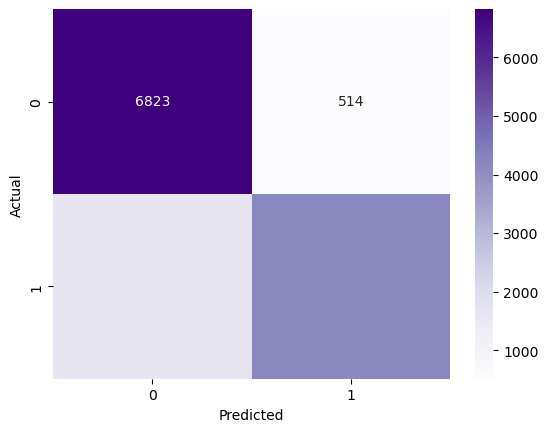

In [181]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [182]:
model.save('../model/pitching_model.h5')  # Save the model